In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycuda.autoinit
import warnings
import time
import cpuinfo
import os
from pycuda.tools import make_default_context
from pycuda import driver, compiler, tools, gpuarray
warnings.filterwarnings('ignore')

In [2]:
os.environ['PATH'] += ';' + r"C:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.29.30133\bin\Hostx64\x64"

In [3]:
def MATRIX_MULTIPLICATION_GPU(matrix_a, matrix_b, matrix_dimension, bdim, gdim):
    kernel = '''
    __global__ void MatrixMulKernel(float *a, float *b, float *c, const int DIMENSION){
        int COLUMN = threadIdx.x + blockIdx.x * blockDim.x;
        int ROW =  threadIdx.y + blockIdx.y * blockDim.y;
        for(int i = 0; i < DIMENSION; i++){
            c[COLUMN + ROW * DIMENSION] += a[i + ROW * DIMENSION] * b[COLUMN + i * DIMENSION];
        }       
}
'''
    matrix_c = gpuarray.empty((matrix_dimension, matrix_dimension), np.float32)
    matrixmul = compiler.SourceModule(kernel).get_function('MatrixMulKernel')
    matrixmul(matrix_a, matrix_b, matrix_c, matrix_dimension, block=bdim, grid=gdim)
    return matrix_c

In [4]:
def MATRIX_MULTIPLICATION_CPU(matrix_a, matrix_b, matrix_c):
    for i in range(len(matrix_a)):
        for j in range(len(matrix_b[0])):
            for k in range(len(matrix_b)):
                matrix_c[i][j] += matrix_a[i][k] * matrix_b[k][j]
    return matrix_c

In [5]:
DIMENSIONS = [128, 256, 512]
TIME_CPU = []
TIME_GPU = []
DIFFERENCE_CPU_GPU = []

print(f'GPU: {tools.make_default_context().get_device().name()}')
print(f'CPU: {cpuinfo.get_cpu_info()["brand_raw"]}')
print()

for size in DIMENSIONS:
    # Создаём данные
    matrix_a = np.random.randn(size, size).astype(np.float32)
    matrix_b = np.random.randn(size, size).astype(np.float32)
    matrix_c = np.zeros(shape=(matrix_a.shape[0], matrix_b.shape[1]))
    
    # Вычисляем время на CPU
    CPU_START = time.time()
    CPU = MATRIX_MULTIPLICATION_CPU(matrix_a, matrix_b, matrix_c)
    CPU_TIME = time.time() - CPU_START
    TIME_CPU.append(CPU_TIME)
    
    # Вычисляем время на GPU
    GPU_START = time.time()
    if size > 32:
        gdim, remains = divmod(size, 32)
        bdim = (32,32,1)
        gdim = (gdim + (remains > 0), gdim + (remains > 0))
    else:
        bdim = (size, size, 1)
        gdim = (1,1)
    matrix_a_gpu = gpuarray.to_gpu(matrix_a)
    matrix_b_gpu = gpuarray.to_gpu(matrix_b)
    GPU = MATRIX_MULTIPLICATION_GPU(matrix_a_gpu, matrix_b_gpu, np.int32(size), bdim, gdim)
    GPU_TIME = time.time() - GPU_START
    TIME_GPU.append(GPU_TIME)
    
    # Вычисляем разницу между CPU & GPU
    DIFFERENCE_TIME = CPU_TIME - GPU_TIME
    DIFFERENCE_CPU_GPU.append(DIFFERENCE_TIME)
    
    print(f'Размерность матрицы: {size}')
    print(f'Время выполнения на CPU: {CPU_TIME:.3f}')
    print(f'Время выполнения на GPU: {GPU_TIME:.3f}')
    print(f'Разница между CPU & GPU: {DIFFERENCE_TIME:.3f}')
    print()

GPU: NVIDIA GeForce GTX 1060 with Max-Q Design
CPU: Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz

Размерность матрицы: 128
Время выполнения на CPU: 2.080
Время выполнения на GPU: 0.382
Разница между CPU & GPU: 1.698

Размерность матрицы: 256
Время выполнения на CPU: 17.441
Время выполнения на GPU: 0.002
Разница между CPU & GPU: 17.439

Размерность матрицы: 512
Время выполнения на CPU: 146.498
Время выполнения на GPU: 0.006
Разница между CPU & GPU: 146.492



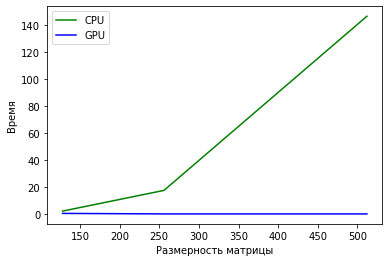

In [6]:
plt.plot(DIMENSIONS, TIME_CPU, color='green', label='CPU')
plt.plot(DIMENSIONS, TIME_GPU, color='blue', label='GPU')
plt.xlabel('Размерность матрицы')
plt.ylabel('Время')
plt.legend()

In [7]:
df = pd.DataFrame({
    'MATRIX_DIMENSION': DIMENSIONS,
    'CPU': TIME_CPU,
    'GPU': TIME_GPU,
})

In [8]:
df.to_excel('gpu_vs_cpu.xlsx', index=False)